In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleandataset/augmented_dataset_2.npz
/kaggle/input/cleandataset/cleanedDataset.npz


In [2]:

from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


In [3]:
import numpy as np

# Load the .npz file
data = np.load("/kaggle/input/cleandataset/cleanedDataset.npz")

# List all keys (names of arrays in the archive)
print(data.files)

['X_train', 'y_train', 'X_test']


In [4]:
data = np.load("/kaggle/input/cleandataset/cleanedDataset.npz")

X_train = data["X_train"]
y_train = data["y_train"]

X_test = data["X_test"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


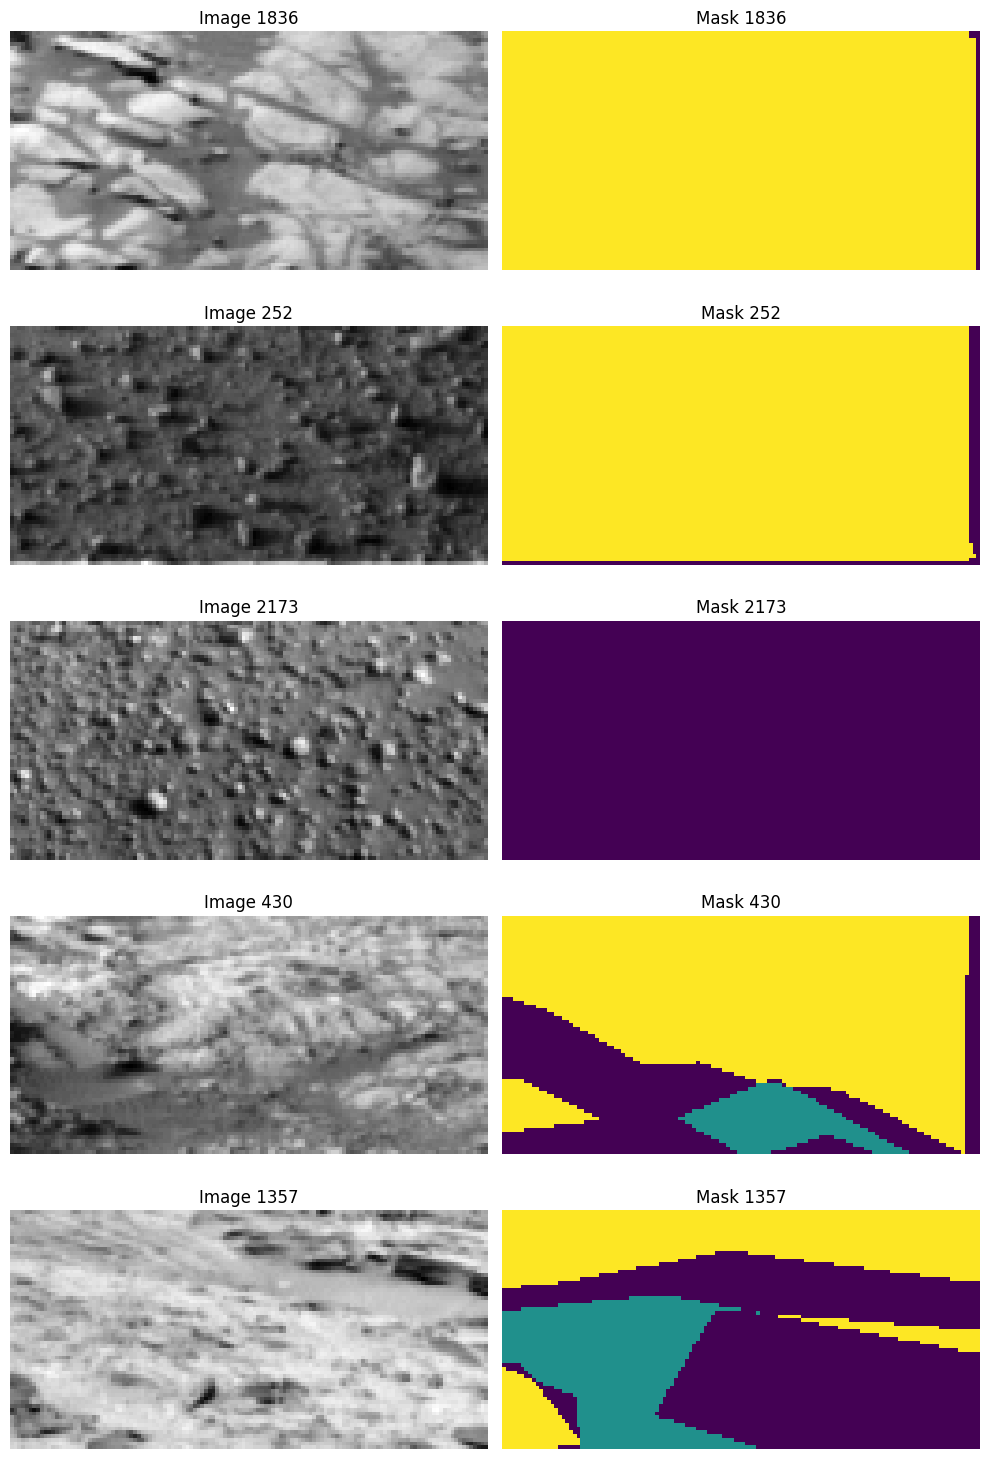

In [5]:


# Select 5 random indices
random_indices = np.random.choice(len(X_train), 5, replace=False)

# Plot the images and their masks
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, idx in enumerate(random_indices):
    # Display image
    axes[i, 0].imshow(X_train[idx].squeeze(), cmap="gray")
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis("off")
    
    # Display mask
    axes[i, 1].imshow(y_train[idx], cmap="viridis")
    axes[i, 1].set_title(f"Mask {idx}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

THis is to check the representation of the different classes in the images

In [6]:
pip install albumentations

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [7]:
flattened_labels = y_train.flatten()

# Get unique classes and their counts
unique_classes, class_counts = np.unique(flattened_labels, return_counts=True)

# Calculate percentage for each class
total_pixels = flattened_labels.size
class_percentages = (class_counts / total_pixels) * 100

# Display results
print("Class Distribution in y_train:")
for cls, percentage in zip(unique_classes, class_percentages):
    print(f"Class {cls}: {percentage:.2f}%")

Class Distribution in y_train:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [8]:
import albumentations as A
import numpy as np
import cv2

# Define the augmentation pipeline for semantic segmentation
transform1 = A.Compose([
    #A.RandomCrop(width=128, height=64, always_apply=True),  # Crop to keep dimensions consistent
    A.HorizontalFlip(p=1),  # Random horizontal flip
], additional_targets={'mask': 'mask'})  # Make sure mask is also augmented

transform2 = A.Compose([
    #A.Rotate(limit=30, p=0.8),  # Random rotation between -30 and 30 degrees
    A.VerticalFlip(p=1)
    #A.RandomScale(scale_limit=0.2, p=0.5),  # Random scaling of the image
], additional_targets={'mask': 'mask'})

transform3 = A.Compose([
    #A.Blur(blur_limit=3, p=0.2),  # Add some blur
    #A.RandomBrightnessContrast(p=0.2),
    #A.Zoom(p=0.8)# Random brightness/contrast adjustments
    A.SafeRotate(p=0.95)
], additional_targets={'mask': 'mask'})

#transform4 = A.Compose([
#    A.GaussNoise(var_limit=(10, 50), p=0.2),  # Add random Gaussian noise
#    A.CLAHE(clip_limit=2.0, p=0.2),  # Apply Contrast Limited Adaptive Histogram Equalization
#], additional_targets={'mask': 'mask'})

# List of transforms
transforms = [transform1, transform2,transform3]

# Augment the entire dataset and store the augmented images and masks
augmented_images = []
augmented_masks = []

# Assuming X_train and y_train are your dataset
# Apply 4 different augmentations to each image
for transform in transforms:
    for idx in range(len(X_train)):  # Iterate over each image in the dataset
        original_image = X_train[idx]
        original_mask = y_train[idx]

        # Ensure correct type for image and mask (float32 for image)
        original_image = np.float32(original_image)  # Convert image to float32
        original_mask = np.uint8(original_mask)  # Ensure mask is uint8

        # Apply the current transformation
        augmented = transform(image=original_image, mask=original_mask)
        aug_image = augmented['image']
        aug_mask = augmented['mask']

        # Ensure that images and masks are consistent in shape (128x64)
        aug_image = cv2.resize(aug_image, (128, 64))  # Resize image to ensure it's 128x64
        aug_mask = cv2.resize(aug_mask, (128, 64), interpolation=cv2.INTER_NEAREST)  # Resize mask to ensure it's 128x64

        # Make sure the image has 3 channels (if RGB) and the mask is single-channel
        if len(aug_image.shape) == 2:  # If the image is grayscale
            aug_image = np.expand_dims(aug_image, axis=-1)  # Add a channel dimension

        # Append augmented images and masks to the lists
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)





/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
num_augmentations_2 = 40  # Number of augmentations per image

for transform in transforms:
    for idx in range(len(X_train)):  # Iterate over each image in the dataset
        original_image = X_train[idx]
        original_mask = y_train[idx]

        # Check if the mask contains class 4
        if 4 in np.unique(original_mask):  # Only process masks containing class 4
            for _ in range(num_augmentations_2):  # Perform multiple augmentations
                # Ensure correct type for image and mask (float32 for image)
                original_image = np.float32(original_image)  # Convert image to float32
                original_mask = np.uint8(original_mask)  # Ensure mask is uint8

                # Apply the current transformation
                augmented = transform(image=original_image, mask=original_mask)
                aug_image = augmented['image']
                aug_mask = augmented['mask']

                # Ensure that images and masks are consistent in shape (128x64)
                aug_image = cv2.resize(aug_image, (128, 64))  # Resize image to ensure it's 128x64
                aug_mask = cv2.resize(aug_mask, (128, 64), interpolation=cv2.INTER_NEAREST)  # Resize mask to ensure it's 128x64

                # Make sure the image has 3 channels (if RGB) and the mask is single-channel
                if len(aug_image.shape) == 2:  # If the image is grayscale
                    aug_image = np.expand_dims(aug_image, axis=-1)  # Add a channel dimension

                # Append augmented images and masks to the lists
                augmented_images.append(aug_image)
                augmented_masks.append(aug_mask)


In [10]:
# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Check shapes of the arrays
print(f"Augmented images shape: {augmented_images.shape}")
print(f"Augmented masks shape: {augmented_masks.shape}")

# Save the augmented dataset to a .npz file
np.savez('/kaggle/working/augmented_dataset_only_geom_2.npz', images=augmented_images, masks=augmented_masks)

# Check the saved dataset
print(f"Saved augmented dataset with {augmented_images.shape[0]} images.")

Augmented images shape: (15075, 64, 128, 1)
Augmented masks shape: (15075, 64, 128)
Saved augmented dataset with 15075 images.


In [11]:

flattened_labels = augmented_masks.flatten()

# Get unique classes and their counts
unique_classes, class_counts = np.unique(flattened_labels, return_counts=True)

# Calculate percentage for each class
total_pixels = flattened_labels.size
class_percentages = (class_counts / total_pixels) * 100

# Display results
print("Class Distribution in y_train:")
for cls, percentage in zip(unique_classes, class_percentages):
    print(f"Class {cls}: {percentage:.2f}%")

Class Distribution in y_train:
Class 0: 35.10%
Class 1: 24.22%
Class 2: 19.05%
Class 3: 18.94%
Class 4: 2.69%
